# Project 2: Segmentation

### What to Submit
Submit this iPython Notebook--containing all your code for the programming exercises below--on [learning suite](https://learningsuite.byu.edu/).

Your notebook file should produce the relevant plots and also provide a short write-up with answers to the questions below.

Please also fill in here the time that each part took you:
* 1. Setting up PyMaxFlow: <span style="color:red;">1.5 hrs</span>
* 2. Getting your first successful segmentation: <span style="color:red;">4 hours</span>
* 3. Adjusting parameters (e.g. $\lambda$, $\sigma$) and so forth, to get good results: <span style="color:red;">1 hour</span>
* 4. Completing the write-up: <span style="color:red;">15 min</span>

Note that there are two folders within the project.  We have provided some images for you to use in testing your implementation, in the `provided images` folder along with their ground-truth segmentations to compare your results to.  Along with these, we want you to provide 2-4 additional images that you select on which you show your results.  <i>Please use the `provided_images` in that path and place any others in the `user_data` folder, and load all of the images (or user input point location files) via the approapriate relative path.  We will drop your notebook file and your `user_data` folder into our folder (which will have the `provided_images` already) and then run your notebook.</i>




## Preparation:
So that you can focus on the elements of the cost function ( the link weights), you may use a existing implementation of the actual min-cut algorithm itself.  You set up the graph, but it will take care of finding the minimum cut.

For this assignment we will be using a python library called PyMaxFlow.  This library is a python wrapper around the original C++ implementation of the min-cut code from [Vladimir Kolmogorov](http://pub.ist.ac.at/%7Evnk/software.html) (who has co-authored several papers on this subject).    

Note: For windows users, you will need the Visual C++ compiler in order for PyMaxFlow to work.  If you already have Visual Studio, this shouldn't be a problem but if you just want the compiler without Visual Studio, you can download [Build Tools For Visual Studio 2017](https://visualstudio.microsoft.com/downloads/#build-tools-for-visual-studio-2017). Once you have access to the Visual C++ compiler look at the next paragraph for PyMaxFlow installation.

PyMaxFlow requires Cython, which should come standard in your anaconda environment but the command to install that will also be included.  To install PyMaxFlow enter the following commands replacing "YourEnvironmentName" with the name of your anaconda environment.
~~~
conda activate YourEnvironemntName
conda install cython
pip install pymaxflow
~~~
Once PyMaxFlow is installed, to understand how to use the library, there is a great [tutorial page](http://pmneila.github.io/PyMaxflow/tutorial.html) that shows how to get started with some simple examples.  Do the "first example" and perhaps the "binary image restoration" as well.

In [1]:
# Needs Matplotlib==2.2.3 and networtx==2.3

In [2]:
import maxflow
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
import json

def color2gray(image):
    
    result = image[:, :, 0] * 0.299 + image[:, :, 1] * 0.587 + image[:, :, 2] * 0.114

    return result

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

# a = np.array([[1, 2, 3], [4, 5, 6]])
# print(a.shape)
# json_dump = json.dumps({'a': a, 'aa': [2, (2, 3, 4), a], 'bb': [2]}, cls=NumpyEncoder)
# print(json_dump)

In [4]:
 %pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm  # notebook compatible
plt.rcParams['figure.figsize'] = [15,8]
plt.rcParams['axes.titlesize'] = '16'
plt.rcParams['axes.titleweight'] = 'bold'

import cv2
def just_title(title):
    a = plt.gca()
    a.set_title(title, fontdict={'fontsize': rcParams['axes.titlesize'],
                                 'fontweight' : rcParams['axes.titleweight'],
                                 'verticalalignment': 'baseline',
                                 'horizontalalignment': 'center'})
    a.set_xticks([])
    a.set_yticks([])
    
    
def color2gray(image):
    result = image[:, :, 0] * 0.299 + image[:, :, 1] * 0.587 + image[:, :, 2] * 0.114
    return result



## Annotations:
Graph cut segmentation is an interactive algorithm requiring the user to provide foreground and background seeds.  Provided is a python file that will open a gui and allow you to annotate the image.  This gui is optional and will require additional packages to be installed into your environment.  To install the packages open a terminal and enter the following commands:
~~~
conda activate YourEnvironmentName
conda install scikit-image pillow
~~~
You can use the gui in the following way:
```python
import guiseg
fore, back = guiseg.get_fore_back(image)
image[fore]  # the foreground seeds
image[back]  # the background seeds
```

For the `guiseg` routine to run, I also found it necssary to install PIL ImageTk (For me, it was `sudo apt install python3-pil.imagetk` but it will be different for Conda).

In [6]:
import guiseg
import cv2
import os

use_gui = False
all_images_given = ["banana.png", "llama.jpg", "penguin.png", "simplecircle.png", "teddy.png"]
all_images_given = [f'provided_images/{image_path}' for image_path in all_images_given]

all_images_user = ["camo_lizard.jpg", "cloud.jpg"]
all_images_user = [f'user_data/{image_path}' for image_path in all_images_user]


if not os.path.isfile("user_data/selections.json"):
    new_json_array = {}
else:
    with open("user_data/selections.json", "r") as fout:
        new_json_array = json.load(fout)


if use_gui:
    for image_path in all_images_user + all_images_given:
        print("Loading", image_path)
        imageBGR = cv2.imread(image_path);
        image = imageBGR[:,:,::-1]; # I reverse the BGR from OpenCV to BGR

        # When the GUI pops up, you can pick either the "Foreground" or "Background" buttons to
        # select pixels to be respective seeds.  Once you're finished, click "Return"
        fore, back = guiseg.get_fore_back(image)
        new_json_array[image_path] = {"fore": fore, "back": back}
    with open("user_data/selections.json", "w") as fout:
        json.dump(new_json_array, fout, cls=NumpyEncoder)
else:
   pass 
    

        



## Graph Cut:
Your code should read in an image and a set of seed pixels and use graph-cut segmentation to segment the image.

You will need to calculate the costs for the t-links (region terms) and the n-links (boundary terms). See the book, the notes/slides, or published papers in this area for ideas of how to define these.  Remember that the t-link weights to a particular terminal (foreground or background) should be large if that pixel looks a lot like the respective foreground/background seeds. The n-link weights should be large if the two neighboring pixels are similar.

Here is [the original paper on graph-cut segmentation](http://www.csd.uwo.ca/~yuri/Papers/iccv01.pdf), which might help with some ideas, but you should look at the literature to see what other costs functions / link weights others have used.

Once the graph is built, use the min-cut algorithm to partition the graph into nodes connected to the foreground node or to the background node, then use these as the resulting labels for the segmentation. Display this result graphically in some fashion overlaid on the input image.  It is best to start with simple images whose foreground and background colors are pretty different and for ones where the edges are pretty clear.  Graph-cut segmentation struggles sometimes with long, thin structures, so you should avoid these types of images early on.



In [7]:
def get_boundary_term(pixel1, pixel2, sigma=1):
    if (pixel1 == pixel2).all():
        return 0
    assert pixel1.shape == pixel2.shape, "shapes are not the same"
    norm = np.linalg.norm(pixel1 - pixel2)
    final_value = -1 * np.square(norm) / (2 * sigma*sigma)
    return np.exp(final_value)
    
# test function
print(get_boundary_term(np.array([0, 0, 0]), np.array([0, 0, 0.1]), sigma=0.01))
print(get_boundary_term(np.array([0, 0, 0]), np.array([0, 0, 0]), sigma=0.2))

print(get_boundary_term(np.array([0, 0, 0]), np.array([0, 0, 0.1]), sigma=1))
print(get_boundary_term(np.array([0, 0, 0]), np.array([0, 0, 0]), sigma=1))

1.9287498479639042e-22
0
0.9950124791926823
0


In [8]:
def get_markings(image, fore, back):
    gray_img = color2gray(image)
    gray_img[:, :] = 255/2

    points = list(zip(*fore))
    for point in points:
        gray_img[point[0], point[1]] = 0

    points = list(zip(*back))
    for point in points:
        gray_img[point[0], point[1]] = 255
    return gray_img

In [9]:
from sklearn.neighbors import KernelDensity

def get_region_term(pixels, kde):
    pixels = pixels.reshape(1, 3)
    return -1 * kde.score_samples(pixels)

# test the function
image_path = "provided_images/banana.png"
selection_dict = new_json_array[image_path]
imageBGR = cv2.imread(image_path);
image = imageBGR[:,:,::-1]; # I reverse the BGR from OpenCV to BGR
kde_fore = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(image[selection_dict["fore"]])
kde_back = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(image[selection_dict["back"]])
print("Fore region probs is", get_region_term(image[0, 0], kde_fore))
print("Back region probs is", get_region_term(image[0, 0, :], kde_back))

Fore region probs is [479.44617314]
Back region probs is [8204.26532759]


/Users/orionweller/Personal/cs450/jupyter_env/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sys.path[0] == '':
/Users/orionweller/Personal/cs450/jupyter_env/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]


In [10]:
# setup graph
def get_segmentation(image, fore, back, sigma=1, bandwidth=0.2):
    print("Creating KDEs and graph...")
    kde_fore = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(image[fore])
    kde_back = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(image[back])

    G = maxflow.Graph[float]()
    dims = image.shape[:2]
    nodeids = G.add_grid_nodes(dims)
    fore_matrix = np.zeros(image.shape[:2])
    back_matrix = np.zeros(image.shape[:2])

    neigbor_matrix_up = np.zeros(image.shape[:2])
    neigbor_matrix_left = np.zeros(image.shape[:2])

    print("getting values for image...")
    for row_num in tqdm(range(image.shape[0])):
        for col_num in range(image.shape[1]):
            fore_prob = get_region_term(image[row_num, col_num], kde_fore)
            back_prob = get_region_term(image[row_num, col_num], kde_back)

            fore_matrix[row_num, col_num] = fore_prob
            back_matrix[row_num, col_num] = back_prob

            # left neighbor
            if row_num > 0:
                boundary_score = get_boundary_term(image[row_num, col_num], image[row_num - 1, col_num], sigma=sigma)
                neigbor_matrix_up[row_num, col_num] = boundary_score

            # up neighbor
            if col_num > 0:
                boundary_score = get_boundary_term(image[row_num, col_num], image[row_num, col_num - 1], sigma=sigma)
                neigbor_matrix_left[row_num, col_num] = boundary_score
                
    print("adding edges to graph...")            
    G.add_grid_tedges(nodeids, back_matrix, fore_matrix)
    G.add_grid_edges(nodeids, weights=neigbor_matrix_left, structure=[[0,0,0],[0,0,1],[0,0,0]])
    G.add_grid_edges(nodeids, weights=neigbor_matrix_up, structure=[[0,0,0],[0,0,0],[0,1,0]]) 
    
    flow = G.maxflow()
    print("Maximum flow:", flow)
    
    mask = G.get_grid_segments(nodeids)
    return mask

In [32]:
# Generate results Here (again, add additional cells to your heart's content)

image_path = "provided_images/banana.png"
selection_dict = new_json_array[image_path]
fore = selection_dict["fore"]
back = selection_dict["back"]
imageBGR = cv2.imread(image_path);
image = imageBGR[:,:,::-1]; # I reverse the BGR from OpenCV to BGR
mask_output = get_segmentation(image, fore, back, bandwidth=0.1)

Creating KDEs and graph...
getting values for image...


/Users/orionweller/Personal/cs450/jupyter_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  after removing the cwd from sys.path.
/Users/orionweller/Personal/cs450/jupyter_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """



adding edges to graph...
Maximum flow: 185636557.8643656


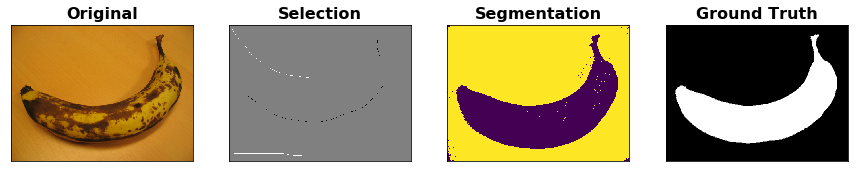

In [33]:
plt.subplot(141)
plt.imshow(image)
just_title("Original")

plt.subplot(142)
markings = get_markings(image, fore, back)
plt.imshow(markings, cmap="gray")
just_title("Selection")

plt.subplot(143)
plt.imshow(mask_output)
just_title("Segmentation")

plt.subplot(144)
truth = cv2.imread(f'provided_images/ground_truth/banana-seg.png')
plt.imshow(truth)
just_title("Ground Truth")

In [34]:
image_path = "provided_images/llama.jpg"
selection_dict = new_json_array[image_path]
fore = selection_dict["fore"]
back = selection_dict["back"]
imageBGR = cv2.imread(image_path);
image = imageBGR[:,:,::-1]; # I reverse the BGR from OpenCV to BGR
mask_output = get_segmentation(image, fore, back, sigma=0.01, bandwidth=0.05)

Creating KDEs and graph...
getting values for image...


/Users/orionweller/Personal/cs450/jupyter_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  after removing the cwd from sys.path.
/Users/orionweller/Personal/cs450/jupyter_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """



adding edges to graph...
Maximum flow: 470271234.20268124


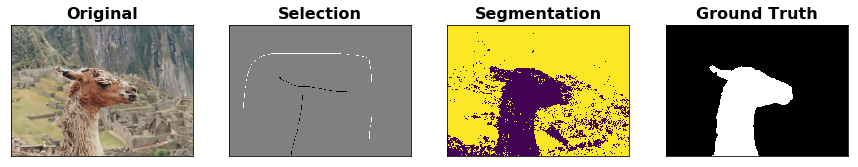

In [35]:
plt.subplot(141)
plt.imshow(image)
just_title("Original")

plt.subplot(142)
markings = get_markings(image, fore, back)
plt.imshow(markings, cmap="gray")
just_title("Selection")

plt.subplot(143)
plt.imshow(mask_output)
just_title("Segmentation")

plt.subplot(144)
truth = cv2.imread('provided_images/ground_truth/llama-seg.png')
plt.imshow(truth)
just_title("Ground Truth")

In [36]:
image_path = "provided_images/penguin.png"
selection_dict = new_json_array[image_path]
fore = selection_dict["fore"]
back = selection_dict["back"]
imageBGR = cv2.imread(image_path);
image = imageBGR[:,:,::-1]; # I reverse the BGR from OpenCV to BGR
mask_output = get_segmentation(image, fore, back, sigma=0.5, bandwidth=0.01)

Creating KDEs and graph...
getting values for image...


/Users/orionweller/Personal/cs450/jupyter_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  after removing the cwd from sys.path.
/Users/orionweller/Personal/cs450/jupyter_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """



adding edges to graph...
Maximum flow: 14505741265.779139


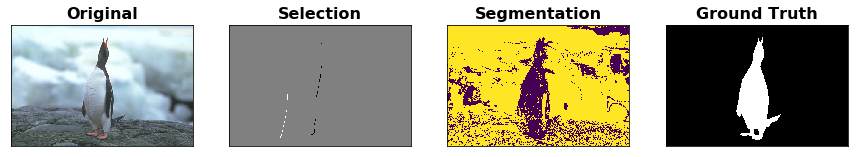

In [37]:
plt.subplot(141)
plt.imshow(image)
just_title("Original")

plt.subplot(142)
markings = get_markings(image, fore, back)
plt.imshow(markings, cmap="gray")
just_title("Selection")

plt.subplot(143)
plt.imshow(mask_output)
just_title("Segmentation")

plt.subplot(144)
truth = cv2.imread('provided_images/ground_truth/penguin-seg.png')
plt.imshow(truth)
just_title("Ground Truth")

In [38]:
image_path = "provided_images/simplecircle.png"
selection_dict = new_json_array[image_path]
fore = selection_dict["fore"]
back = selection_dict["back"]
imageBGR = cv2.imread(image_path);
image = imageBGR[:,:,::-1]; # I reverse the BGR from OpenCV to BGR
mask_output = get_segmentation(image, fore, back)

Creating KDEs and graph...
getting values for image...


/Users/orionweller/Personal/cs450/jupyter_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  after removing the cwd from sys.path.
/Users/orionweller/Personal/cs450/jupyter_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """



adding edges to graph...
Maximum flow: 10233679.798064416


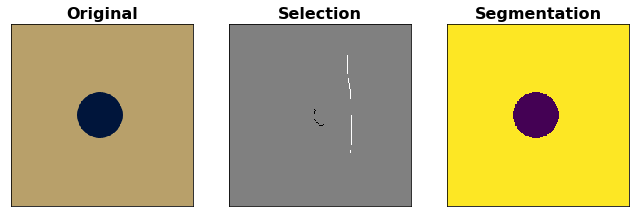

In [39]:
plt.subplot(141)
plt.imshow(image)
just_title("Original")

plt.subplot(142)
markings = get_markings(image, fore, back)
plt.imshow(markings, cmap="gray")
just_title("Selection")

plt.subplot(143)
plt.imshow(mask_output)
just_title("Segmentation")

In [40]:
image_path = "provided_images/teddy.png"
selection_dict = new_json_array[image_path]
fore = selection_dict["fore"]
back = selection_dict["back"]
imageBGR = cv2.imread(image_path);
image = imageBGR[:,:,::-1]; # I reverse the BGR from OpenCV to BGR
mask_output = get_segmentation(image, fore, back)

Creating KDEs and graph...
getting values for image...


/Users/orionweller/Personal/cs450/jupyter_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  after removing the cwd from sys.path.
/Users/orionweller/Personal/cs450/jupyter_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """



adding edges to graph...
Maximum flow: 57718001.20004978


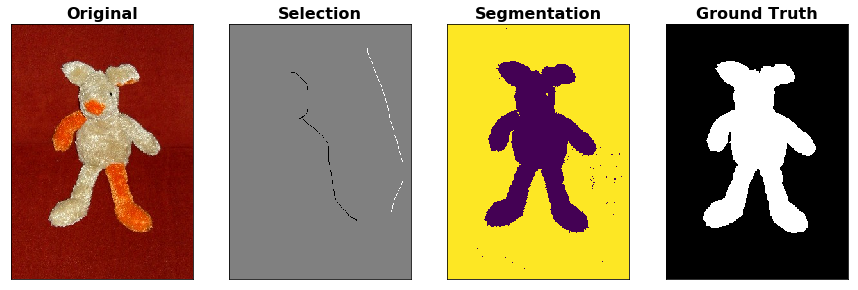

In [41]:
plt.subplot(141)
plt.imshow(image)
just_title("Original")

plt.subplot(142)
markings = get_markings(image, fore, back)
plt.imshow(markings, cmap="gray")
just_title("Selection")

plt.subplot(143)
plt.imshow(mask_output)
just_title("Segmentation")

plt.subplot(144)
truth = cv2.imread('provided_images/ground_truth/teddy-seg.png')
plt.imshow(truth)
just_title("Ground Truth")

In [28]:
### Easy One ###
image_path = "user_data/cloud.jpg"
selection_dict = new_json_array[image_path]
fore = selection_dict["fore"]
back = selection_dict["back"]
imageBGR = cv2.imread(image_path);
image = imageBGR[:,:,::-1]; # I reverse the BGR from OpenCV to BGR
mask_output = get_segmentation(image, fore, back)

Creating KDEs and graph...
getting values for image...


/Users/orionweller/Personal/cs450/jupyter_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  after removing the cwd from sys.path.
/Users/orionweller/Personal/cs450/jupyter_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """



adding edges to graph...
Maximum flow: 260273058.41181394


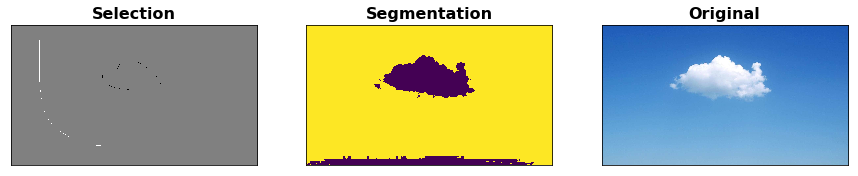

In [29]:
plt.subplot(131)
markings = get_markings(image, fore, back)
plt.imshow(markings, cmap="gray")
just_title("Selection")

plt.subplot(132)
plt.imshow(mask_output)
just_title("Segmentation")

plt.subplot(133)
plt.imshow(image)
just_title("Original")

In [23]:
### Very hard one, due to camo ###
image_path = "user_data/camo_lizard.jpg"
selection_dict = new_json_array[image_path]
fore = selection_dict["fore"]
back = selection_dict["back"]
imageBGR = cv2.imread(image_path);
image = imageBGR[:,:,::-1]; # I reverse the BGR from OpenCV to BGR
mask_output = get_segmentation(image, fore, back)

Creating KDEs and graph...
getting values for image...


/Users/orionweller/Personal/cs450/jupyter_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  after removing the cwd from sys.path.
/Users/orionweller/Personal/cs450/jupyter_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """



adding edges to graph...
Maximum flow: 340125459.0991784


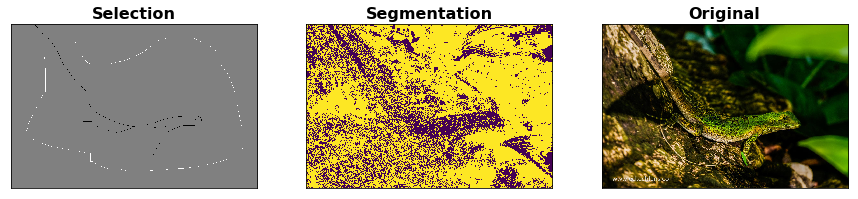

In [26]:
plt.subplot(131)
markings = get_markings(image, fore, back)
plt.imshow(markings, cmap="gray")
just_title("Selection")

plt.subplot(132)
plt.imshow(mask_output)
just_title("Segmentation")

plt.subplot(133)
plt.imshow(image)
just_title("Original")


## Grading / Rubric
Points for this assigment will be assigned as follows (100 points total):
* [20 pts] Code that correctly generates the graph network structure (nodes, n-links, t-links).
* [10 pts] Code that produces the boundary term $B(p,q)$ used for n-links.
* [10 pts] Code that produces the region term of the cost $R(p,A)$ used for the t-links.  Remember that you have t-links per pixel, one with cost determined by matching $p$ with the foreground appearance distribution, the other determined relative to the background distribution.  You may use the [sk-learn implementation](https://scikit-learn.org/stable/modules/density.html#kernel-density-estimation) of Kernel Density Estimation.  However you will receive 10 extra points if you implement it yourself.
* [20 pts] Implementing the graph-cut with `pymaxflow` and finding the optimal solution for the input graph.
* [10 pts] Displaying Results in the following format (for each input image you'll show the following 3-4 result images):
   1. Original Image.
   2. Tri-map of what was selected by the user (white for foreground, black for background, gray for unknown).  This can be overlaid on top of a faint copy of the image for context if desired.
   3. Final segmentation.  Again you can overlay it on a faint copy of the original for context.
   4. On the <i>provided images</i> please show a comparison of your resulting segmentaiton with the ground truth.
* [20 pts] Good (certainly not perfect, some of them are challenging, but decent/reasonable) results on the 4 provided images (banana, llama, penguin, teddy).  Each image will receive up to 5 points.
* [10 pts] Demonstrating your algorithm on 2-4 additional images.  At least one of the images should be somewhat easy, one should be somewhat challenging -- expalin why you think they're respectively easy/challenging.


## Write-up:
Provide an explanation for the following items:
* Describe how you determinied/computed the n-link and t-link weights.
* What kinds of image does graph cut segmentation work well for? What kinds of images do you find it struggles with?
* What did you learn from the project?
* What if any suggestions do you have for improving it (for future students)?

<span style="color:blue;">I computed the n-links according to what was talked about in class, using the boundary term (which was used a gaussian kernel to weight the differences in the kernels).  FOr the t-links I used the negative log likelihood of that pixel's similarity to the foreground or background, depedning on what pixels were selected in that space.  To implement the log likelihood, I used Kernel Density Estimateion.</span>

<span style="color:blue;">My segmentation works well for things that have clear differences (in texture or color) as well as those that are more uniform in color and texture.  It struggled on the penguin (I think due to the color differences on the penguin) and the llama (the background was similar in color). On my own images, it struggled with the camoflagued lizard, since it blended in so well.</span>

<span style="color:blue;">I learned that the functions you define for the graph cut algorithm make a big difference in segmentation. I also learned how to formulate a real life problem as a graph cut algorithm, which is cool.  I was impressed by what you could do with the simple functions.</span>

<span style="color:blue;">My suggestion would be to have some sort of explanation of what the PyMaxFlow does, most of my work was trying to understand how it worked (the structure and weights) and what format it expected.  It's hard to debug too, since its hard to print out the graph, etc.  Other than that though, it was a fun lab!</span>